
**Anomaly Detection Algorithm using Gaussian Mixture Model**



I am working with a credit card fraud dataset. This dataset contains 28 key features, which are not directly interpretable but contain meaningful information about the dataset.


In [1]:
pip install wget  

In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (2).gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [5]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [6]:
df.shape[0]

284807

In [7]:
df.shape[1]

31

It's important when looking at a new dataset to figure out how many examples we have for each class.

* What is the percentage of entries in the dataset for each class? **Class 0 - 99.83% ; Class 1 - 0.17%** 
* Is this data considered balanced or unbalanced? Why is this the case? **The data is unbalanced because the percentage of class 1 values is insignificant compared to the percentage of class 0 values** 
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **As the data is unbalanced, the model might predict every class as class 0 and still run with an accuracy of 99%. This leads to bias due to the underrepresentation of class 1 in the sample dataset provided. Moreover, the results on the training and validation sets can be misleading and cause erroneous conclusions as the model cannot even detect Fraudulent Transactions** 



In [8]:
np.unique(df['Class'],return_counts=True)

(array([0, 1]), array([284315,    492]))

In [9]:
No_of_each_label = np.unique(df['Class'],return_counts=True)
percentage_0 = (No_of_each_label[1][0]/df.shape[0])*100
percentage_1 = (No_of_each_label[1][1]/df.shape[0])*100
print(percentage_0, percentage_1)

99.82725143693798 0.1727485630620034


Next, I split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. 

In [10]:
### Split the data  ###
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train_m, X_test, y_train_m, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_m, y_train_m, test_size=(15*100)/85/100, random_state=1)




Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

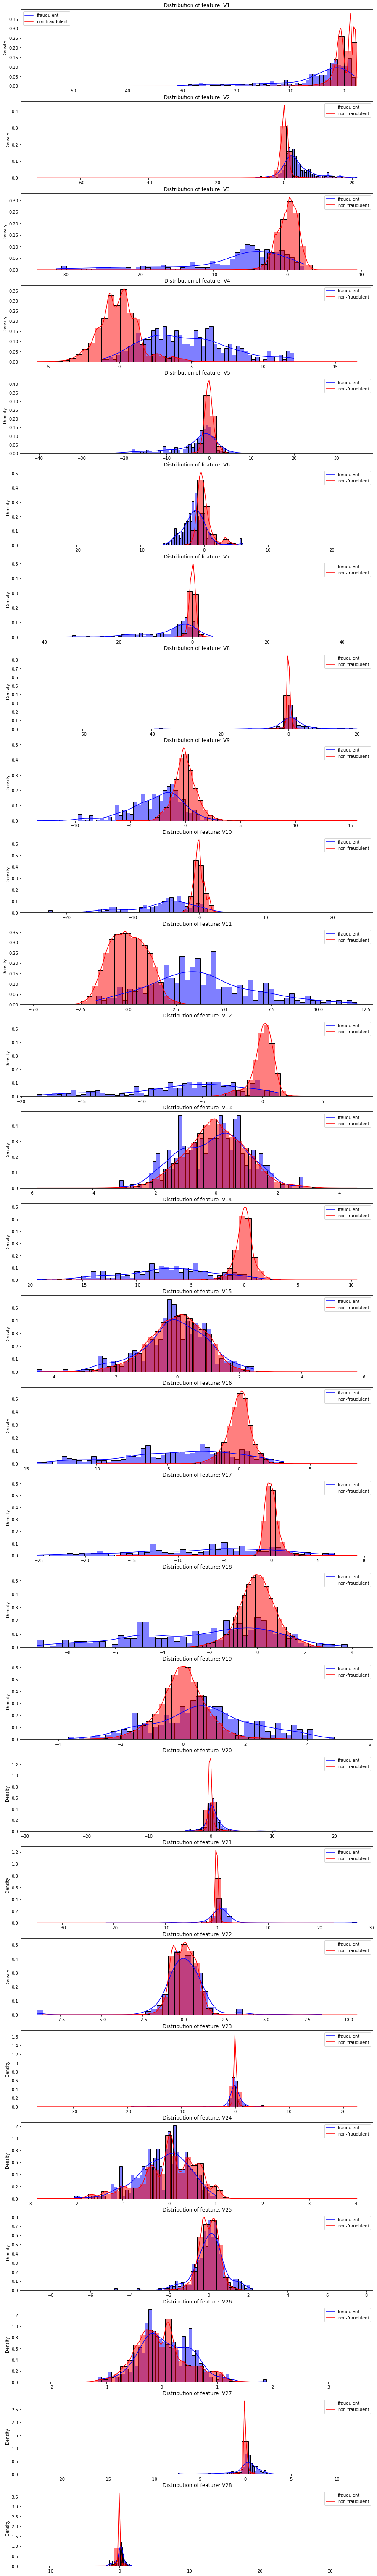

In [11]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**




1.   Through these graphs, we can identify how the fraudulent and non-fraudulent datasets are distributed.
2.   We get a rough sense of the mean and how far away the data is distributed from the center 
3.   We can also estimate the approximate number of Gaussian Distributions (clusters) can be fitted for each features. 
4.   In most of the cases we can see that the range of the fraudulent transactions is significantly lesser than the non-fraudulent transactions, strengthening our understanding that the dataset is unbalanced.
5. Some distributions such as in 'V1' and 'V3', we can clearly see that the density curve is left tailed, and there are outliers





## **Single feature model with one Gaussian distribution:
I am making predictions by fitting the Gaussian DIstribution to one feature at a time, calculating AUC scores and maximizing F1 scores.



In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Creating functions that fits a dataset into a gaussian distribution, can calculate,AUC scores log weighted probablity scores for each sample and the entire model as well.
def fit_model(X, no_components):
    
    gm = GaussianMixture(n_components = no_components, covariance_type = 'full', random_state=1)
    try:
      gm.fit(np.array([X]).reshape(-1, len(X.T)))
    except:
      gm.fit(np.array([X]).reshape(-1,1))
    return gm

def AUC_Score_SG(gm, x_score, y, log_gmm_score = 'No', need_plot = 'No'):
  try:
    pgm = gm.score_samples(np.array([x_score]).reshape(-1,len(x_score.T)))
    fpr, tpr, threshold_ = roc_curve(y, 1-pgm)
    AUC_ = auc(fpr, tpr)
  except:
    pgm = gm.score_samples(np.array([x_score]).reshape(-1,1))
    fpr, tpr, threshold_ = roc_curve(y, 1-pgm)
    AUC_ = auc(fpr, tpr)
  if(log_gmm_score =='No' and need_plot == 'No' ):
    return pgm, AUC_
  elif(log_gmm_score =='YES' and need_plot == 'No' ):
    return pgm, AUC_, gm.score(x_score)
  elif(log_gmm_score =='YES' and need_plot == 'YES'):
    return pgm, fpr, tpr, AUC_, gm.score(x_score)
  else:
    return pgm, fpr, tpr, AUC_

In [13]:

auc_list = []
gaus_main_list = []
features=df.columns[:-1] 
for i, feat in enumerate(features):
    gm_one_feat = fit_model(X_train[feat], no_components = 1)
    pgm_train, fpr_train, tpr_train, AUC_train = AUC_Score_SG(gm_one_feat, X_train[feat], y_train, log_gmm_score = 'No', need_plot = 'YES')
    pgm_val, fpr_val, tpr_val, AUC_val = AUC_Score_SG(gm_one_feat, X_val[feat], y_val, log_gmm_score = 'No', need_plot = 'YES')
    gaus_main_list.append([feat, pgm_train, fpr_train, tpr_train, AUC_train, pgm_val, fpr_val, tpr_val, AUC_val])
    auc_list.append([feat, AUC_train, AUC_val, pgm_val])

In [14]:
#Combining all the scores into a dataframe and sorting it to get the best AUC scores.
auc_df = pd.DataFrame(auc_list, columns = ['features', 'AUC_train', 'AUC_val', 'pgm_val'])
auc_df = auc_df.sort_values(by = ['AUC_val'], ascending = False).reset_index(drop=True)

print("The AUC scores for the training and validation sets are shown for each feature")
auc_df.iloc[:,0:3]

The AUC scores for the training and validation sets are shown for each feature


,features,AUC_train,AUC_val
0,V14,0.953383,0.944183
1,V11,0.901979,0.940452
2,V10,0.909411,0.939923
3,V16,0.904845,0.922616
4,V12,0.915303,0.921743
5,V17,0.936587,0.921198
6,V3,0.865412,0.917957
7,V4,0.901294,0.865136
8,V27,0.823743,0.863662
9,V7,0.876917,0.841375


Text(0.5, 1.0, 'ROC Curve for V14')

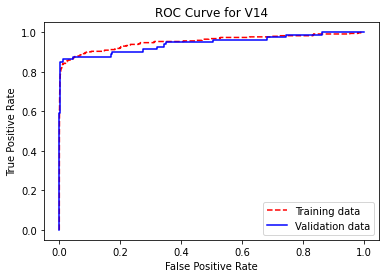

In [16]:
#plotting the ROC curve for the best Feature 

plt.plot(gaus_main_list[14][2], gaus_main_list[14][3], color = 'red', linestyle = '--', label=  'Training data')
plt.plot(gaus_main_list[14][6], gaus_main_list[14][7],color = 'blue', label = 'Validation data')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for V14")

In [18]:
from sklearn.metrics import f1_score

x = auc_df.loc[0, "pgm_val"]
#creating a function that calculates the best F1_Score using log probability values of each sample on the validation set

def Best_F1_score(x, y_val, need_plot = 'No', range_step = 50):
  x_sorted = list(sorted(x))
  threshold = []
  F1_score = []
  max_val = 0
  best_threshold = 0
  c = 0
  for i in range(0, len(x), range_step):
    threshold.append(x_sorted[i])
    F1_score.append(f1_score(y_val, x < threshold[c]))
    #print(F1_score[i])
    if(c == 0 or max_val < F1_score[c] ):
      max_val = F1_score[c]
      best_threshold = threshold[c]
      c+=1
  if(need_plot == 'No'):
    return max_val, best_threshold
  else:
    return max_val, best_threshold, threshold, F1_score




In [19]:
#Calculating maximum scores and theshold for the feature with best validation AUC score
maximum_F1, best_threshold, threshold, F1_score = Best_F1_score(x, y_val, 'YES')

In [20]:
print("Maximum F1 score on the Validation set is",maximum_F1)

Maximum F1 score on the Validation set is 0.6077348066298343


In [21]:
print("The threshold for the maximum F1 score on the Validation set is", best_threshold)

The threshold for the maximum F1 score on the Validation set is -15.1163685550017


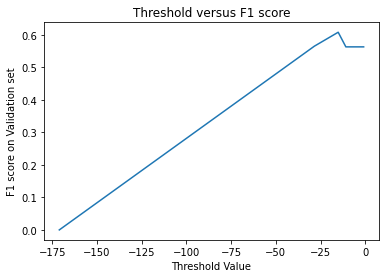

In [22]:
#Plotting threshold value with its corresponding F1 score
#plt.figure(figsize = (20,5))
plt.plot(threshold, F1_score)
plt.xlabel("Threshold Value")
plt.ylabel("F1 score on Validation set")
plt.title("Threshold versus F1 score")
plt.show()

In [23]:
#fitting to only non-fraudulent transactions
auc_list_nf = []
gaus_main_list_nf = []
features=df.columns[:-1] 
for i, feat in enumerate(features):
    gm_one_feat_nf = fit_model(X_train.loc[df['Class'] == 0, feat], no_components = 1)
    pgm_train_nf, fpr_train_nf, tpr_train_nf, AUC_train_nf = AUC_Score_SG(gm_one_feat_nf, X_train[feat], y_train,  need_plot = 'Yes')
    pgm_val_nf, fpr_val_nf, tpr_val_nf, AUC_val_nf = AUC_Score_SG( gm_one_feat_nf, X_val[feat], y_val, need_plot = 'Yes' )
    gaus_main_list_nf.append([feat, pgm_train_nf, fpr_train_nf, tpr_train_nf, AUC_train_nf, pgm_val_nf, fpr_val_nf, tpr_val_nf, AUC_val_nf])
    auc_list_nf.append([feat, AUC_train_nf, AUC_val_nf, pgm_val_nf])


In [24]:
#Combining all the scores into a dataframe and sorting it to get the best AUC scores.
auc_df_nf = pd.DataFrame(auc_list_nf, columns = ['features', 'AUC_train_nf', 'AUC_val_nf', 'pgm_val_nf'])
auc_df_nf = auc_df_nf.sort_values(by = ['AUC_val_nf', 'AUC_train_nf'], ascending = False).reset_index(drop=True)
auc_df_nf.iloc[:, 0:3]

,features,AUC_train_nf,AUC_val_nf
0,V14,0.953639,0.943930
1,V11,0.902311,0.940666
2,V10,0.909431,0.940099
3,V12,0.915953,0.922726
4,V16,0.904715,0.922601
5,V17,0.936348,0.920398
6,V3,0.866164,0.918681
7,V4,0.901882,0.865496
8,V27,0.823837,0.863636
9,V7,0.876990,0.841730


In [25]:
x_nf = auc_df_nf.iloc[0, 3]

In [26]:
max_nf, best_threshold_nf, threshold_nf, F1_score_nf = Best_F1_score(x, y_val, 'YES')

In [27]:
print("Maximum F1 score on the Validation set with only Valid Transactions is", max_nf)
print("The threshold for the maximum F1 score on the Validation set with Valid Transactions is", best_threshold_nf)

Maximum F1 score on the Validation set with only Valid Transactions is 0.6077348066298343
The threshold for the maximum F1 score on the Validation set with Valid Transactions is -15.1163685550017


In [28]:
#part 6  fitting to fraudulent transactions 
auc_list_f = []
gaus_main_list_f = []
features=df.columns[:-1] 
for i, feat in enumerate(features):
    gm_one_feat_f = fit_model(X_train.loc[df['Class'] == 1, feat], no_components = 1)
    pgm_train_f, fpr_train_f, tpr_train_f, AUC_train_f = AUC_Score_SG(gm_one_feat_f, X_train[feat], y_train,  need_plot = 'Yes')
    pgm_val_f, fpr_val_f, tpr_val_f, AUC_val_f = AUC_Score_SG(gm_one_feat_f, X_val[feat], y_val, need_plot = 'Yes' )
    gaus_main_list_f.append([feat, pgm_train_f, fpr_train_f, tpr_train_f, AUC_train_f, pgm_val_f, fpr_val_f, tpr_val_f, AUC_val_f])
    auc_list_f.append([feat, AUC_train_f, AUC_val_f, pgm_val_f])

In [29]:
auc_df_f = pd.DataFrame(auc_list_f, columns = ['features', 'AUC_train_f', 'AUC_val_f', 'pgm_val_f'])
auc_df_f = auc_df_f.sort_values(by = ['AUC_val_f', 'AUC_train_f'], ascending = False).reset_index(drop=True)
auc_df_f.iloc[:, 0:3]

,features,AUC_train_f,AUC_val_f
0,V27,0.774524,0.812941
1,V28,0.759227,0.739070
2,V23,0.667753,0.667364
3,V8,0.642831,0.657578
4,Amount,0.623137,0.626742
5,V13,0.554996,0.602966
6,V25,0.566662,0.598435
7,V19,0.587997,0.598035
8,V22,0.553728,0.565526
9,V20,0.542025,0.522802


In [30]:
x_f = auc_df_f.iloc[0, 3]
max_f, best_threshold_f, threshold_f, F1_score_f = Best_F1_score(x, y_val, 'YES', range_step=100)

In [31]:
print("Maximum F1 score on the Validation set with only Valid Transactions is", max_f)
print("The threshold for the maximum F1 score on the Validation set with Valid Transactions is", best_threshold_f)

Maximum F1 score on the Validation set with only Valid Transactions is 0.6077348066298343
The threshold for the maximum F1 score on the Validation set with Valid Transactions is -15.1163685550017




*  Even though we only fit the Gaussian Distribution to the non-fraudulent data set and calculate the probability samples of the entire dataset, because the non-fraudulent data is very large and the fraudulent dataset is very insignificant compared to non-fraudulent. the model's performance does not significantly (Unbalanced Dataset).
*   The AUC scores varies only a tad bit, but the best performing features are the same. Also, the threshold and the F1 scores are the same as well.
*   Whereas, if we fit the fraudulent transactions as a model and then calculate AUC scores, there is a significant drop in the AUC scores, and the features that have the best AUC scores are different. This suggests that the model is altered and it does not perform that well. Not only are the number of data points less to learn from, but also there is only positive values in the training data






## **Multiple feature model with one Gaussian distribution:**
This part is similar to the above model, but here I will pick multiple features and set the number of components visually.

In [32]:
###You can use the following function for 3D plotting in part b  ###

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d(X_train , y_train, f1, f2, f3, angle ):
  X_train_3f = pd.DataFrame(data = X_train,columns=[f1, f2,f3])
  fig = plt.figure()
  ax = plt.axes( projection='3d')
  ax.scatter3D(X_train_3f[f1][y_train==0], X_train_3f[f2][y_train==0], X_train_3f[f3][y_train==0], c='y', marker='x',label ='Non-fraud')
  ax.scatter3D(X_train_3f[f1][y_train==1], X_train_3f[f2][y_train==1], X_train_3f[f3][y_train==1], c='r', marker='o',label="Fraud")
  ax.set_xlabel(f1)
  ax.set_ylabel(f2)
  ax.set_zlabel(f3)
  plt.legend()
  ax.view_init(30, angle)
  plt.show()


In [34]:
import seaborn as sns

#creating a function that gives the scatter plot for two features from the df

def scatter_plot(feature_1, feature_2):
  plt.figure(figsize = (2, 10))
  train_df = X_train.join(y_train)
  g = sns.lmplot(x = feature_1, y = feature_2, data = train_df , fit_reg = False, hue = 'Class', markers=["o", "x"], palette=['b','r'], scatter_kws={'alpha':0.8},  height=8, aspect= 1, legend = False)
  new_labels = ['fraudulent', 'non-fraudulent']
  plt.legend( loc='upper left', labels=new_labels)
  plt.title("Feature 1 versus Feature 2")
  plt.show(g)


<Figure size 144x720 with 0 Axes>

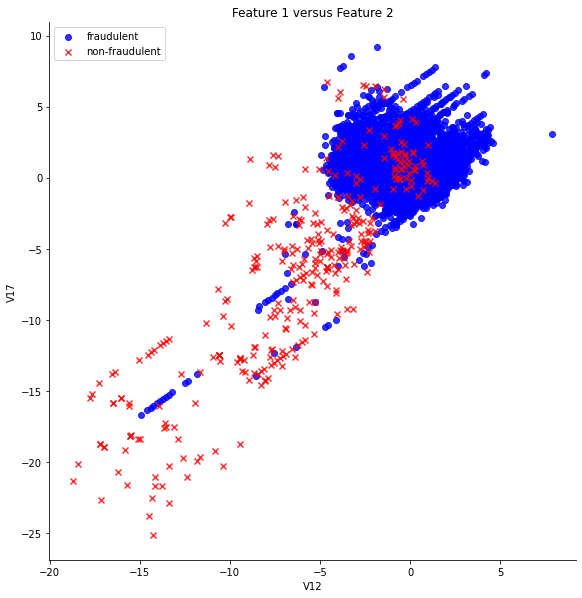

0.9509725804799505 0.9412369999768374


In [35]:
#first set of features
AUC_train_2 = [] 
AUC_val_2 =[]
scatter_plot('V12', 'V17')

#From the scatter plot, we can see that, the non-fraudulent transactions are combined as one single cluster, so we can choose the number of components as 1
gm_two_feat_F1 = fit_model(X_train.loc[:, ['V12', 'V17']], no_components = 1)
pgm_train_F1, fpr_train_F1, tpr_train_F1,AUC_train_F1  = AUC_Score_SG(gm_two_feat_F1, X_train.loc[:, ['V12', 'V17']], y_train, need_plot = 'Yes' )
pgm_val_f1, fpr_val_F1, tpr_val_F1, AUC_val_F1 = AUC_Score_SG(gm_two_feat_F1, X_val.loc[:, ['V12', 'V17']], y_val, need_plot = 'Yes' )

AUC_train_2.append(AUC_train_F1)
AUC_val_2.append(AUC_val_F1)
print(AUC_train_2[0], AUC_val_2[0])

<Figure size 144x720 with 0 Axes>

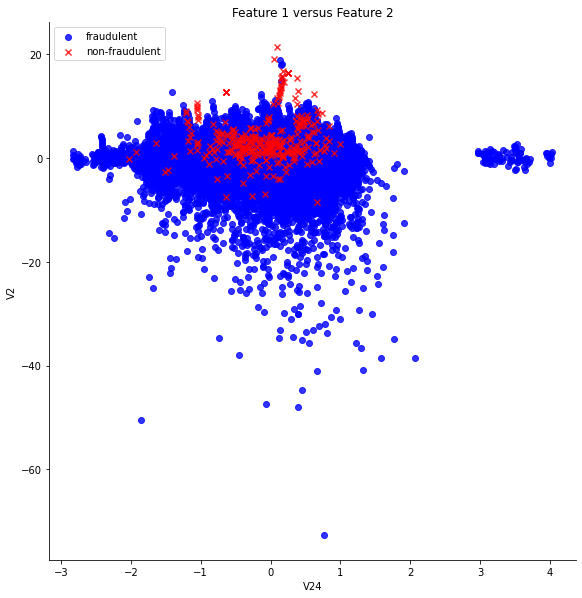

0.7878030293280339 0.7696937321937323


In [36]:
#second set of features
scatter_plot('V24', 'V2')

#From the scatter plot, we can see that, the non-fraudulent transactions are combined as one single cluster, so we can choose the number of components as 1
gm_two_feat_F2 = fit_model(X_train.loc[:, ['V24', 'V2']], no_components = 1)
pgm_train_F2, fpr_train_F2, tpr_train_F2,AUC_train_F2  = AUC_Score_SG(gm_two_feat_F2, X_train.loc[:, ['V24', 'V2']], y_train, need_plot = 'Yes' )
pgm_val_F2, fpr_val_F2, tpr_val_F2, AUC_val_F2 = AUC_Score_SG(gm_two_feat_F2, X_val.loc[:, ['V24', 'V2']], y_val, need_plot = 'Yes' )

AUC_train_2.append(AUC_train_F2)
AUC_val_2.append(AUC_val_F2)
print(AUC_train_2[1], AUC_val_2[1])


<Figure size 144x720 with 0 Axes>

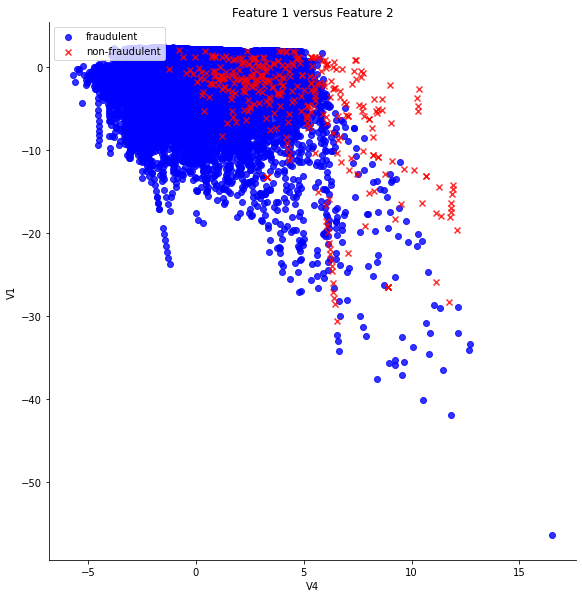

0.9004776779504409 0.8867981724689041


In [37]:
#third set of features
scatter_plot('V4', 'V1')

#From the scatter plot, we can see that, the non-fraudulent transactions are combined as one single cluster, so we can choose the number of components as 1
gm_two_feat_F3 = fit_model(X_train.loc[:, ['V4', 'V1']], no_components = 1)
pgm_train_F3, fpr_train_F3, tpr_train_F3,AUC_train_F3  = AUC_Score_SG(gm_two_feat_F3, X_train.loc[:, ['V4', 'V1']], y_train, need_plot = 'Yes' )
pgm_val_F3, fpr_val_F3, tpr_val_F3, AUC_val_F3 = AUC_Score_SG(gm_two_feat_F3, X_val.loc[:, ['V4', 'V1']], y_val, need_plot = 'Yes' )

AUC_train_2.append(AUC_train_F3)
AUC_val_2.append(AUC_val_F3)
print(AUC_train_F3, AUC_val_F3)

In [40]:
print("AUC train and validation scores for three different features")
AUC_2feat_df = pd.DataFrame(data = np.array([[['V12', 'V17'], ['V24', 'V2'], ['V4', 'V1']], AUC_train_2, AUC_val_2], dtype=object).T, columns = ['Features', 'AUC train scores', 'AUC validation scores'])
AUC_2feat_df = AUC_2feat_df.sort_values(by = ['AUC validation scores'], ascending = False).reset_index(drop=True)
AUC_2feat_df

AUC train and validation scores for three different features


,Features,AUC train scores,AUC validation scores
0,"[V12, V17]",0.950973,0.941237
1,"[V4, V1]",0.900478,0.886798
2,"[V24, V2]",0.787803,0.769694


In [44]:
#first set of features has the maximum AUC scores, therefore we need to find its corresponding best F1 scores on the validation set 

max_F1_score, threshold_for_max, threshold, F1_score = Best_F1_score(pgm_val_f1, y_val, need_plot= 'YES',  range_step=10)

In [45]:
print("Maximum F1 score on the Validation set is", max_F1_score, 'for the features V12, V17')
print("The threshold for the maximum F1 score on the Validation set", threshold_for_max, 'for the features V12, V17')

Maximum F1 score on the Validation set is 0.6808510638297872 for the features V12, V17
The threshold for the maximum F1 score on the Validation set -28.43077665032575 for the features V12, V17


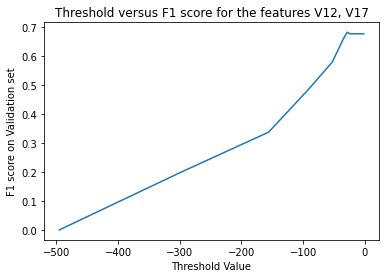

In [46]:
#Plotting threshold value with its corresponding F1 score
#plt.figure(figsize = (20,5))
plt.plot(threshold, F1_score)
plt.xlabel("Threshold Value")
plt.ylabel("F1 score on Validation set")
plt.title("Threshold versus F1 score for the features V12, V17")
plt.show()

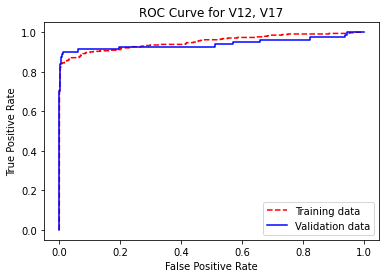

In [47]:
#plotting the ROC curve for the best Feature 

plt.plot(fpr_train_F1, tpr_train_F1, linestyle = '--', color = 'red', label = 'Training data')
plt.plot(fpr_val_F1, tpr_val_F1, color = 'blue', label = 'Validation data')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for V12, V17")
plt.legend()

Text(0.5, 1.0, 'Visual Representation of the model detecting anomalies')

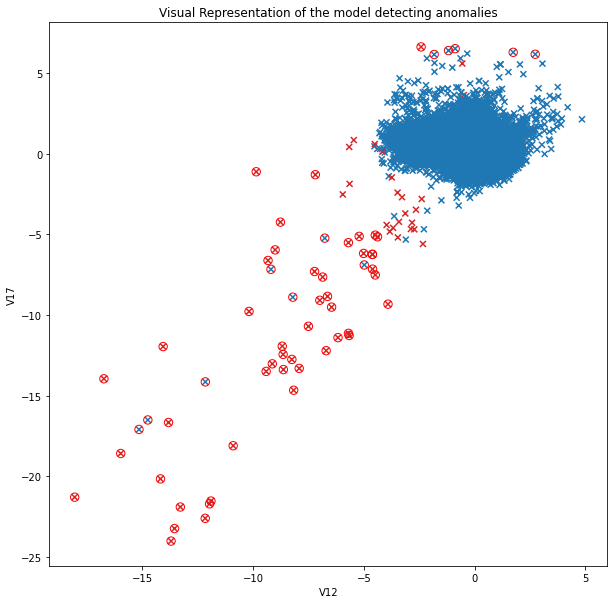

In [48]:
#part 10 - plotting the outliers for the best two features on the Validation set
plt.figure(figsize=(10,10))
val_df = X_val.join(y_val)
colors = {0:'tab:blue', 1:'tab:red'}
plt.scatter(val_df.loc[:, 'V12'], val_df.loc[:, 'V17'], c = val_df['Class'].map(colors), marker='x')
outliers = np.nonzero(pgm_val_f1<threshold_for_max)[0]
plt.scatter(X_val.iloc[outliers, 12],X_val.iloc[outliers, 17], marker="o",facecolor= "none", edgecolor="r", s=70)
plt.xlabel('V12')
plt.ylabel('V17')
plt.title("Visual Representation of the model detecting anomalies")
#plt.show()

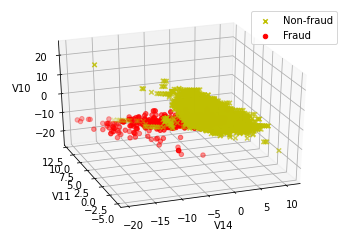

In [49]:
#part 3 b. 

#taking the first three features that have best AUC scores and looking at the 3D plot at different angles to get an idea of number of clusters
col_names = list(auc_df.iloc[:3,0].values)
plot_3d(X_train[col_names], y_train, f1=col_names[0], f2=col_names[1], f3 = col_names[2], angle=250)

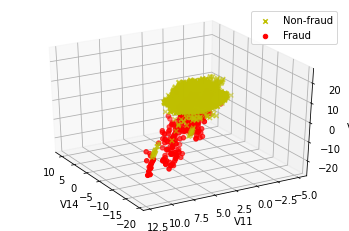

In [50]:
col_names = list(auc_df.iloc[:3,0].values)
plot_3d(X_train[col_names], y_train, f1=col_names[0], f2=col_names[1], f3 = col_names[2], angle=150)

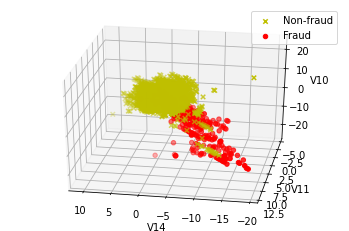

In [51]:
col_names = list(auc_df.iloc[:3,0].values)
plot_3d(X_train[col_names], y_train, f1=col_names[0], f2=col_names[1], f3 = col_names[2], angle=100)

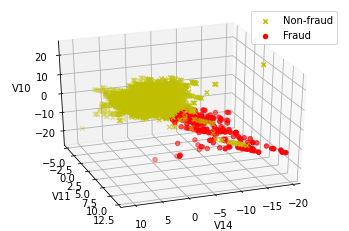

In [52]:
col_names = list(auc_df.iloc[:3,0].values)
plot_3d(X_train[col_names], y_train, f1=col_names[0], f2=col_names[1], f3 = col_names[2], angle=70)

In [55]:
#we can see that the number of clusters for non-fraudulent transactions is 1, therefore, I am calculating the corresponding AUC scores
gm_two_feat_3D = fit_model(X_train.loc[:, ['V14', 'V10', 'V11']], no_components = 1)
pgm_train_3D, fpr_train_3D, tpr_train_3D, AUC_train_3D  = AUC_Score_SG(gm_two_feat_3D, X_train.loc[:,  ['V14', 'V10', 'V11']], y_train, need_plot = 'Yes' )
pgm_val_3D, fpr_val_3D, tpr_val_3D, AUC_val_3D = AUC_Score_SG(gm_two_feat_3D, X_val.loc[:,  ['V14', 'V10', 'V11']], y_val, need_plot = 'Yes' )


print("The AUC Scores for training and Validation dataset for the features V14, V11, V10 are", AUC_train_3D, AUC_val_3D, ", respectively.")


The AUC Scores for training and Validation dataset for the features V14, V11, V10 are 0.9534099965204117 0.9639693790100293 , respectively.


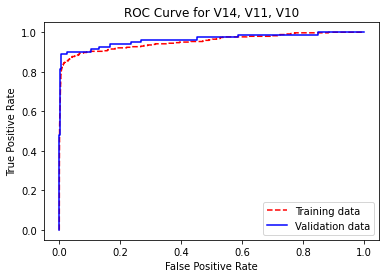

In [56]:
#plotting the ROC curve for the best set of Features

plt.plot(fpr_train_3D, tpr_train_3D, linestyle = '--', color = 'red', label = 'Training data')
plt.plot(fpr_val_3D, tpr_val_3D, color = 'blue', label = 'Validation data')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for V14, V11, V10")
plt.legend()

## **Single feature model with two Gaussian distributions.**
I am fitting separate Gaussians to fraudulent and non-fraudulent transactions

In [57]:
features=X.columns
max_F1_2G_Train = []
max_F1_2G_Val = []
best_threshold_2G = []
for i, feat in enumerate(features):
  G1 = fit_model(X_train.loc[df['Class'] == 0, feat], no_components=1)
  G2 = fit_model(X_train.loc[df['Class'] == 1, feat], no_components=1)
  S1 = G1.score_samples(np.array([X_val[feat]]).reshape(-1, 1))
  S2 = G2.score_samples(np.array([X_val[feat]]).reshape(-1, 1))
  F1_score = []
  max_F1_2G_Val.append(0)
  best_threshold_2G.append(0)
  count = 0
  for j in np.arange(0,50,2):
    F1_score.append(f1_score(y_val.values, S1 < j*S2))
    if(count == 0 or max_F1_2G_Val[i] < F1_score[count]):
      max_F1_2G_Val[i] = F1_score[count]
      best_threshold_2G[i] = j
    count+=1
  S1_train = G1.score_samples(np.array([X_train[feat]]).reshape(-1, 1))
  S2_train = G2.score_samples(np.array([X_train[feat]]).reshape(-1, 1))
  max_F1_2G_Train.append(f1_score(y_train.values, S1_train < best_threshold_2G[i]*S2_train))


In [58]:
Gaussian_2 = pd.DataFrame( np.array([X.columns, max_F1_2G_Train, max_F1_2G_Val, best_threshold_2G]).T , columns = ['Features','max_F1_2G_Train', 'max_F1_2G_Val' , 'best_threshold_2G' ])

In [60]:
print("The results of teo Gaussian Mixture Model for a single feature are shown below")
Gaussian_2 = Gaussian_2.sort_values(by = 'max_F1_2G_Val', ascending = False).reset_index(drop=True)
Gaussian_2

The results of teo Gaussian Mixture Model for a single feature are shown below


,Features,max_F1_2G_Train,max_F1_2G_Val,best_threshold_2G
0,V17,0.656616,0.686131,8
1,V12,0.659574,0.675325,4
2,V14,0.612946,0.666667,6
3,V11,0.572451,0.61194,4
4,V16,0.575188,0.608,6
5,V10,0.440476,0.446281,8
6,V18,0.449679,0.444444,6
7,V4,0.370558,0.375,4
8,V3,0.294931,0.319444,6
9,V9,0.366972,0.306122,4


In [63]:
print("The best feature, best F1 score on training set, best F1 score on Validation set, and the threshold value is \n", Gaussian_2.iloc[0, :] )

The best feature, best F1 score on training set, best F1 score on Validation set, and the threshold value is 
 Features                  V17
max_F1_2G_Train      0.656616
max_F1_2G_Val        0.686131
best_threshold_2G           8
Name: 0, dtype: object


## **Multivariate and Mixture of Gaussians Distribution**
Creating Multiple models and finding which has the maximum scores to use on the test data 

I tried running a single Gaussian model for five features and varied the components from 5 to 100, and calculated the log likelihood scores of the model on validation and training set. The code snippet and the graph is attached below. 
![picture](https://drive.google.com/uc?id=1FzFbL1YE5kYGLeP755wAXPNW11HhmPLN)
```
# This is formatted as code
```log_scores_val_M1 = []
log_scores_train_M1 = []
max_log_val_M1 = 0
max_log_train_M1 = 0
best_comp_M1= 0

model_1_df = pd.DataFrame()
count = 0
for i in (range(5, 101, 5)):
  col_names_M1 = list(auc_df.iloc[:5,0].values)
  gm_M1 = fit_model(X_train.loc[:, col_names_M1], no_components = i)
  pgm_M1_tr, AUC_M1_tr, log_sc_tr= AUC_Score_SG(gm_M1, X_train.loc[:, col_names_M1], y_train, log_gmm_score = 'YES')
  pgm_M1_va, AUC_M1_va, log_sc_v= AUC_Score_SG(gm_M1, X_val.loc[:, col_names_M1], y_val, log_gmm_score = 'YES')
  #train_F1, train_threshold_F1= Best_F1_score(pgm_M1_tr, y_train, range_step= 100)
  #val_F1, val_threshold_F1= Best_F1_score(pgm_M1_va, y_val)  
  log_scores_train_M1.append(log_sc_tr)
  log_scores_val_M1.append(log_sc_v)
  if(count == 0 or max_log_val_M1 < log_scores_val_M1[count]):
    max_log_val_M1= log_scores_val_M1[count]
    max_log_train_M1= log_scores_train_M1[count]
    best_comp_M1 = i
    AUC_M1_train = AUC_M1_tr
    AUC_M1_val = AUC_M1_va
    pgm_M1_val = pgm_M1_va
    pgm_M1_train = pgm_M1_tr
    count+=1

plt.plot(np.arange(5,105,5), log_scores_train_M1, color = 'blue', label = 'Train')
plt.plot(np.arange(5,105,5), log_scores_val_M1, color = 'red', label = 'Validation')
plt.title('Choosing Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Log scores')
plt.legend()




In [157]:
List_2G =[]

In [94]:
List_1G =[]

In [66]:
#MODEL 1
#Five Features, One Gaussian, 10, 20 and 40 components - Finding the F1 score for each model 
#and choosing the best model among these for the final set of 10 models
log_scores_val_M1 = []
log_scores_train_M1 = []


model_1_df = pd.DataFrame()
count = 0
for i in [15,20,40]:
  col_names_M1 = list(auc_df.iloc[:5,0].values)
  gm_M1 = fit_model(X_train.loc[:, col_names_M1], no_components = i)
  pgm_M1_tr, AUC_M1_tr, log_sc_tr= AUC_Score_SG(gm_M1, X_train.loc[:, col_names_M1], y_train, log_gmm_score = 'YES')
  pgm_M1_va, AUC_M1_va, log_sc_v= AUC_Score_SG(gm_M1, X_val.loc[:, col_names_M1], y_val, log_gmm_score = 'YES')
  val_F1, val_threshold_F1= Best_F1_score(pgm_M1_va, y_val) 
  train_F1= f1_score(y_train, pgm_M1_tr < val_threshold_F1) 
  log_scores_train_M1.append(log_sc_tr)
  log_scores_val_M1.append(log_sc_v)
    
  model_1_df = model_1_df.append({
      'AUC Train': AUC_M1_tr,
      'AUC Val': AUC_M1_va,
      'F1 Score (Train)': train_F1,
      'F1 Score (Val)': val_F1,
      'F1 Threshold (Val)': val_threshold_F1,
      'Log Scores (Train)': 1-log_sc_tr,
      'Log Scores (Val)': 1-log_sc_v,
      'Number of Components': i
  }, ignore_index=True)

In [67]:
print("Performance of three different models with features", col_names_M1, "are shown below")
model_1_df= model_1_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_1_df

Performance of three different models with features ['V14', 'V11', 'V10', 'V16', 'V12'] are shown below


,AUC Train,AUC Val,F1 Score (Train),F1 Score (Val),F1 Threshold (Val),Log Scores (Train),Log Scores (Val),Number of Components
0,0.962593,0.966839,0.423490,0.462633,-15.450587,6.594478,6.594192,20.0
1,0.963270,0.969550,0.417191,0.458874,-15.673728,6.464159,6.474155,40.0
2,0.961611,0.968995,0.380874,0.427046,-15.785026,6.688627,6.689481,15.0


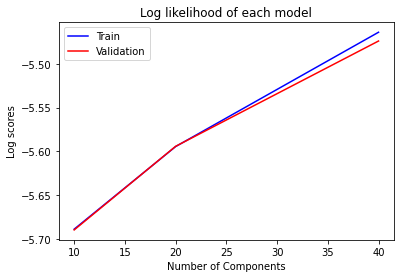

In [70]:
plt.plot(np.array([10,20,40]), log_scores_train_M1, color = 'blue', label = 'Train')
plt.plot(np.array([10,20,40]), log_scores_val_M1, color = 'red', label = 'Validation')
plt.title('Log likelihood of each model')
plt.xlabel('Number of Components')
plt.ylabel('Log scores')
plt.legend()

In [95]:
List_1G.append(['Five Features, One Gaussian, 20 components', col_names_M1, model_1_df.loc[0, 'AUC Train'], model_1_df.loc[0, 'AUC Val'], model_1_df.loc[0, 'F1 Score (Train)'], model_1_df.loc[0, 'F1 Score (Val)'], model_1_df.loc[0, 'F1 Threshold (Val)'], 'N/A'])

In [72]:
#MODEL 2
#Thirteen Features, One Gaussian
#Finding the best number of components by calculating F1 scores for 1 to 10 components
log_scores_val_M2 = []
log_scores_train_M2 = []

model_2_df = pd.DataFrame()
for i in (range(1,11)):
  col_names_M2 = list(auc_df.iloc[2:15,0].values)
  gm_M2 = fit_model(X_train.loc[:, col_names_M2], no_components = i)
  pgm_M2_tr, AUC_M2_tr, log_sc_tr= AUC_Score_SG(gm_M2, X_train.loc[:, col_names_M2], y_train, log_gmm_score = 'YES')
  pgm_M2_va, AUC_M2_va, log_sc_v= AUC_Score_SG(gm_M2, X_val.loc[:, col_names_M2], y_val, log_gmm_score = 'YES')
  val_F1, val_threshold_F1= Best_F1_score(pgm_M2_va, y_val) 
  train_F1= f1_score(y_train, pgm_M2_tr < val_threshold_F1)
  log_scores_train_M2.append(log_sc_tr)
  log_scores_val_M2.append(log_sc_v)

  model_2_df = model_2_df.append({
      'AUC Train': AUC_M2_tr,
      'AUC Val': AUC_M2_va,
      'F1 Score (Train)': train_F1,
      'F1 Score (Val)': val_F1,
      'F1 Threshold (Val)': val_threshold_F1,
      'Log Scores (Train)': 1-log_sc_tr,
      'Log Scores (Val)': 1-log_sc_v,
      'Number of Components': i
  }, ignore_index=True)

In [73]:
print("Performance of ten different models with features", col_names_M2, "are shown below")
model_2_df= model_2_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_2_df

Performance of ten different models with features ['V10', 'V16', 'V12', 'V17', 'V3', 'V4', 'V27', 'V7', 'V2', 'V18', 'V21', 'V5', 'V8'] are shown below


,AUC Train,AUC Val,F1 Score (Train),F1 Score (Val),F1 Threshold (Val),Log Scores (Train),Log Scores (Val),Number of Components
0,0.950183,0.957847,0.287926,0.351145,-279.753146,19.802147,20.032559,1.0
1,0.951050,0.965560,0.307334,0.342541,-55.609275,12.982785,13.063727,4.0
2,0.955199,0.963715,0.280000,0.320611,-76.347403,15.076223,15.116666,2.0
3,0.956163,0.965874,0.269525,0.320611,-61.934891,13.455051,13.487339,3.0
4,0.949863,0.957844,0.271523,0.320442,-43.110940,11.052227,11.077069,5.0
5,0.949525,0.961580,0.259701,0.305344,-47.355418,10.700905,10.719056,6.0
6,0.946513,0.964662,0.256334,0.305344,-48.565211,10.384245,10.400906,7.0
7,0.955087,0.968271,0.305141,0.305344,-55.541992,10.034816,10.086793,8.0
8,0.955275,0.967493,0.222422,0.242424,-38.021234,9.583473,9.617373,9.0
9,0.960263,0.971669,0.148273,0.164502,-35.621794,9.107651,9.123637,10.0


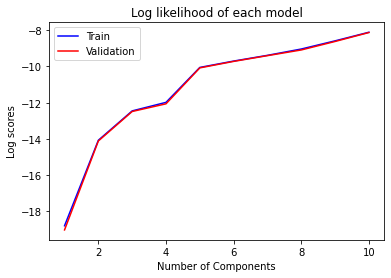

In [74]:
plt.plot(np.arange(1,11,1), log_scores_train_M2, color = 'blue', label = 'Train')
plt.plot(np.arange(1,11,1), log_scores_val_M2, color = 'red', label = 'Validation')
plt.title('Log likelihood of each model')
plt.xlabel('Number of Components')
plt.ylabel('Log scores')
plt.legend()

In [96]:
List_1G.append(['Thirteen Features, One Gaussian, 1 component', col_names_M2, model_2_df.loc[0, 'AUC Train'], model_2_df.loc[0, 'AUC Val'], model_2_df.loc[0, 'F1 Score (Train)'], model_2_df.loc[0, 'F1 Score (Val)'], model_2_df.loc[0, 'F1 Threshold (Val)'], 'N/A'])

<Figure size 144x720 with 0 Axes>

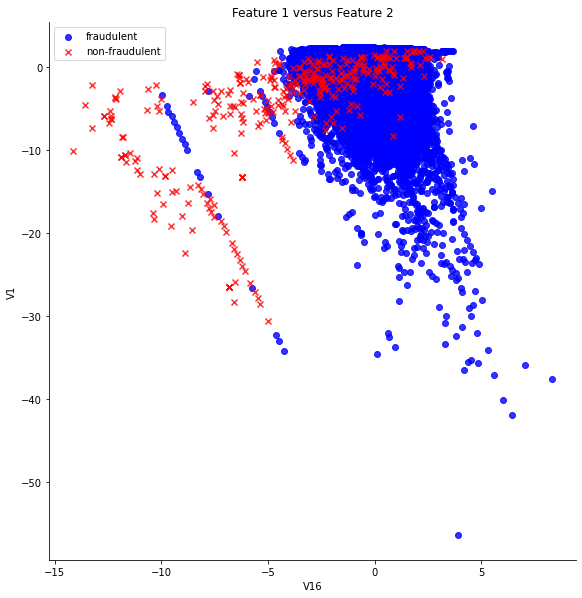

In [76]:
#MODEL 3
#Two Features, 2 Gaussians, 1 component
scatter_plot('V16', 'V1')

In [92]:
#MODEL 3
#Two Features with good AUC values, 2 Gaussians, 1 component

G1_M3 = fit_model(X_train.loc[df['Class'] == 0, ['V16', 'V1']], no_components=1)
G2_M3 = fit_model(X_train.loc[df['Class'] == 1, ['V16', 'V1']], no_components=1)
S1_M3 = G1_M3.score_samples(np.array([X_val.loc[:,['V16', 'V1']]]).reshape(-1, 2))
S2_M3 = G2_M3.score_samples(np.array([X_val.loc[:,['V16', 'V1']]]).reshape(-1, 2))
F1_scores_M3 = []
max_F1_Val_M3 = 0
best_threshold_M3 = 0
count = 0
for j in np.arange(0,10,0.05):
  F1_scores_M3.append(f1_score(y_val.values, S1_M3 < j*S2_M3))
  if count == 0 or max_F1_Val_M3 < F1_scores_M3[count]:
    max_F1_Val_M3 = F1_scores_M3[count]
    best_threshold_M3 = j
  count = count + 1
S1_train_M3 = G1_M3.score_samples(np.array([X_train.loc[:,['V16', 'V1']]]).reshape(-1, 2))
S2_train_M3 = G2_M3.score_samples(np.array([X_train.loc[:,['V16', 'V1']]]).reshape(-1, 2))
max_F1_Train_M3 = f1_score(y_train.values, S1_train_M3 < best_threshold_M3*S2_train_M3)

In [97]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V14'")
model_3_df = pd.DataFrame(np.array([np.arange(0,10,0.05), F1_scores_M3]).T, columns = ['c value', 'F1 score (Validation)'])
model_3_df = model_3_df.sort_values(by = 'F1 score (Validation)', ascending = False).reset_index(drop=True)
model_3_df

The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V14'


,c value,F1 score (Validation)
0,5.25,0.508475
1,5.30,0.508475
2,5.35,0.508475
3,5.40,0.508475
4,5.45,0.508475
...,...,...
195,0.05,0.003785
196,0.30,0.003785
197,0.35,0.003785
198,0.40,0.003785


Text(0.5, 1.0, 'Visual Representation of the model detecting anomalies')

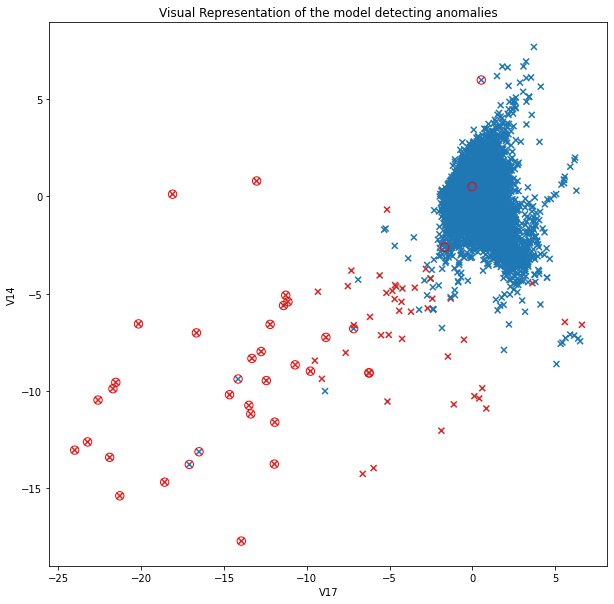

In [98]:
plt.figure(figsize=(10,10))
val_df = X_val.join(y_val)
colors = {0:'tab:blue', 1:'tab:red'}
plt.scatter(val_df.loc[:, 'V17'], val_df.loc[:, 'V14'], c = val_df['Class'].map(colors), marker='x')
outliers = np.nonzero(S1_M3 < best_threshold_M3*S2_M3)[0]
plt.scatter(X_val.iloc[outliers, 17],X_val.iloc[outliers, 14], marker="o",facecolor= "none", edgecolor="r", s=70)
plt.xlabel('V17')
plt.ylabel('V14')
plt.title("Visual Representation of the model detecting anomalies")

In [158]:
List_2G.append(['Two Features, 2 Gaussians, 1 component', ['V17', 'V14'], 'N/A', 'N/A',  max_F1_Train_M3, max_F1_Val_M3, 'N/A', best_threshold_M3])

<Figure size 144x720 with 0 Axes>

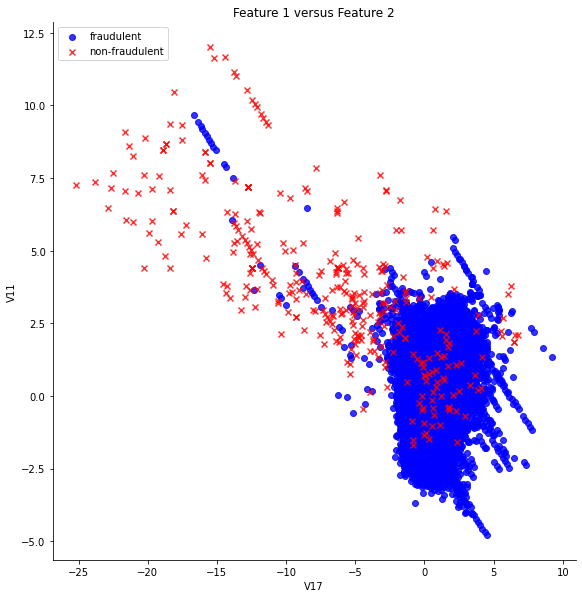

In [100]:
#MODEL 4:
#Two Features with good AUC values, 2 Gaussians, 1 component

scatter_plot('V17', 'V11')

In [81]:
#MODEL 4
#Two Features, 2 Gaussians, 1 component
G1_M4 = fit_model(X_train.loc[df['Class'] == 0, ['V17', 'V11']], no_components=1)
G2_M4 = fit_model(X_train.loc[df['Class'] == 1, ['V17', 'V11']], no_components=1)
S1_M4 = G1_M4.score_samples(np.array([X_val[['V17', 'V11']]]).reshape(-1, 2))
S2_M4 = G2_M4.score_samples(np.array([X_val[['V17', 'V11']]]).reshape(-1, 2))
F1_scores_M4 = []
max_F1_Val_M4 = 0
best_threshold_M4 = 0
count = 0
for j in np.arange(0,10,0.05):
  F1_scores_M4.append(f1_score(y_val.values, S1_M4 < j*S2_M4))
  if count == 0 or max_F1_Val_M4 < F1_scores_M4[count]:
    max_F1_Val_M4 = F1_scores_M4[count]
    best_threshold_M4 = j
  count = count + 1
S1_train_M4 = G1_M4.score_samples(np.array([X_train[['V17', 'V11']]]).reshape(-1, 2))
S2_train_M4 = G2_M4.score_samples(np.array([X_train[['V17', 'V11']]]).reshape(-1, 2))
max_F1_Train_M4 = f1_score(y_train.values, S1_train_M4 < best_threshold_M4*S2_train_M4)

In [82]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V11'")
model_4_df = pd.DataFrame(np.array([np.arange(0,10,0.05), F1_scores_M4]).T, columns = ['c value', 'F1 score (Validation)'])
model_4_df = model_4_df.sort_values(by = 'F1 score (Validation)', ascending = False).reset_index(drop=True)
model_4_df

The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V11'


,c value,F1 score (Validation)
0,5.85,0.737589
1,5.50,0.736111
2,5.55,0.736111
3,5.60,0.736111
4,5.65,0.736111
...,...,...
195,0.10,0.003785
196,0.05,0.003785
197,0.20,0.003785
198,0.25,0.003785


Text(0.5, 1.0, 'Visual Representation of the model detecting anomalies')

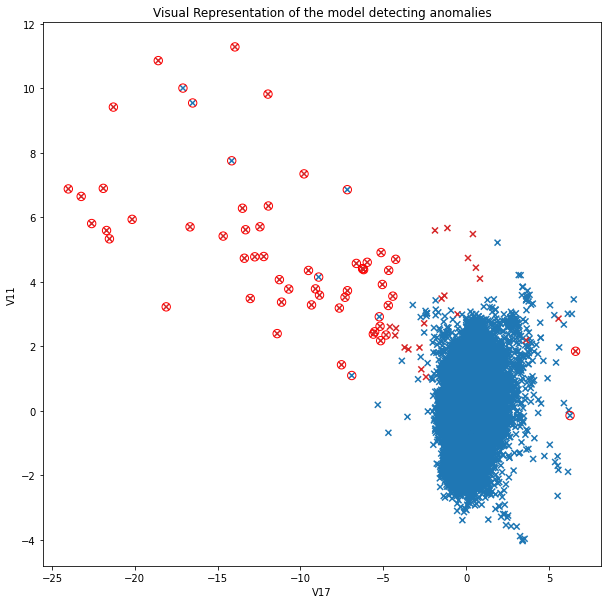

In [90]:
plt.figure(figsize=(10,10))
val_df = X_val.join(y_val)
colors = {0:'tab:blue', 1:'tab:red'}
plt.scatter(val_df.loc[:, 'V17'], val_df.loc[:, 'V11'], c = val_df['Class'].map(colors), marker='x')
outliers = np.nonzero(S1_M4 < best_threshold_M4*S2_M4)[0]
plt.scatter(X_val.iloc[outliers, 17],X_val.iloc[outliers, 11], marker="o",facecolor= "none", edgecolor="r", s=70)
plt.xlabel('V17')
plt.ylabel('V11')
plt.title("Visual Representation of the model detecting anomalies")

In [159]:
List_2G.append(['Two Features, 2 Gaussians, 1 component', ['V17', 'V11'], 'N/A', 'N/A', max_F1_Train_M4, max_F1_Val_M4, 'N/A', best_threshold_M4])

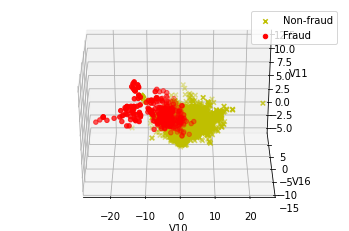

In [84]:
#MODEL 5
#Three Features, 2 Gaussians, 1 component
plot_3d(X_train, y_train, f1="V10", f2="V16", f3="V11", angle=270)

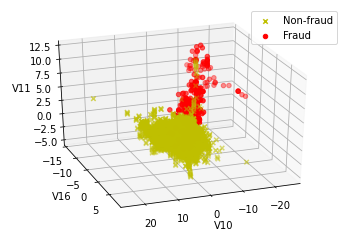

In [85]:
#MODEL 5
#Three Features, 2 Gaussians, 1 component
plot_3d(X_train, y_train, f1="V10", f2="V16", f3="V11", angle=70 )

In [86]:
#MODEL 5
G1_M5 = fit_model(X_train.loc[df['Class'] == 0, ['V10', 'V16', 'V11']], no_components=1)
G2_M5 = fit_model(X_train.loc[df['Class'] == 1, ['V10', 'V16', 'V11']], no_components=1)
S1_M5 = G1_M5.score_samples(np.array([X_val[['V10', 'V16', 'V11']]]).reshape(-1, 3))
S2_M5 = G2_M5.score_samples(np.array([X_val[['V10', 'V16', 'V11']]]).reshape(-1, 3))
F1_scores_M5 = []
max_F1_Val_M5 = 0
best_threshold_M5 = 0
count = 0
for j in np.arange(0,10,0.05):
  F1_scores_M5.append(f1_score(y_val.values, S1_M5 < j*S2_M5))
  if count == 0 or max_F1_Val_M5 < F1_scores_M5[count]:
    max_F1_Val_M5 = F1_scores_M5[count]
    best_threshold_M5 = j
  count = count + 1
S1_train_M5 = G1_M5.score_samples(np.array([X_train[['V10', 'V16', 'V11']]]).reshape(-1, 3))
S2_train_M5 = G2_M5.score_samples(np.array([X_train[['V10', 'V16', 'V11']]]).reshape(-1, 3))
max_F1_Train_M5 = f1_score(y_train.values, S1_train_M5 < best_threshold_M5*S2_train_M5)

In [87]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V11'")
model_5_df = pd.DataFrame(np.array([np.arange(0,10,0.05), F1_scores_M5]).T, columns = ['c value', 'F1 score (Validation)'])
model_5_df = model_5_df.sort_values(by = 'F1 score (Validation)', ascending = False).reset_index(drop=True)
model_5_df

The F1 scores of the validation set based on different thresholds for a model fit on the features 'V17', 'V11'


,c value,F1 score (Validation)
0,3.90,0.757143
1,3.95,0.753623
2,3.85,0.751773
3,3.80,0.741259
4,3.75,0.736111
...,...,...
195,0.05,0.003785
196,0.25,0.003785
197,0.30,0.003785
198,0.35,0.003785


In [160]:
List_2G.append(['Three Features, 2 Gaussians, 1 component',['V10', 'V16', 'V11'], 'N/A', 'N/A', max_F1_Train_M5, max_F1_Val_M5,  'N/A', best_threshold_M5 ])

In [89]:
#MODEL 6 - two Gaussian, six features, valid transactions 1 component, invalid - finding best number of component out of 20
#by calculating the best F1 score on the validation set 
model_6_df = pd.DataFrame()

#choosing the features with the best AUC scores

col_names_M6 = list(auc_df.iloc[0:6,0].values)
for i in (range(1,20)):
  G1_M6 = fit_model(X_train.loc[df['Class'] == 0, col_names_M6], no_components=1)
  G2_M6 = fit_model(X_train.loc[df['Class'] == 1, col_names_M6], no_components=i)
  S1_M6 = G1_M6.score_samples(np.array([X_val[col_names_M6]]).reshape(-1, 6))
  S2_M6 = G2_M6.score_samples(np.array([X_val[col_names_M6]]).reshape(-1, 6))
  S1_train_M6 = G1_M6.score_samples(np.array([X_train[col_names_M6]]).reshape(-1, 6))
  S2_train_M6 = G2_M6.score_samples(np.array([X_train[col_names_M6]]).reshape(-1, 6))
  F1_scores_M6 = []
  max_F1_Val_M6 = 0
  best_threshold_M6 = 0
  count = 0
  for j in np.arange(0,10,0.05):
    F1_scores_M6.append(f1_score(y_val.values, S1_M6 < j*S2_M6))
    if count == 0 or max_F1_Val_M6 < F1_scores_M6[count]:
      max_F1_Val_M6 = F1_scores_M6[count]
      best_threshold_M6 = j
    count = count + 1
  max_F1_Train_M6 = f1_score(y_train.values, S1_train_M6 < best_threshold_M6*S2_train_M6)
  model_6_df = model_6_df.append({
      'F1 Score (Train)': max_F1_Train_M6,
      'F1 Score (Val)': max_F1_Val_M6,
      'C value (Val)': best_threshold_M6,
      'Number of Components': i
  }, ignore_index=True)


In [103]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features", col_names_M6, 'are shown you')
model_6_df = model_6_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_6_df

The F1 scores of the validation set based on different thresholds for a model fit on the features ['V14', 'V11', 'V10', 'V16', 'V12', 'V17'] are shown you


,C value (Val),F1 Score (Train),F1 Score (Val),Number of Components
0,6.55,0.819423,0.886076,10.0
1,7.80,0.793798,0.883117,3.0
2,7.80,0.793798,0.883117,4.0
3,6.50,0.816388,0.880503,6.0
4,6.50,0.816388,0.880503,7.0
5,7.00,0.815267,0.878981,11.0
6,7.25,0.814132,0.877419,9.0
7,6.40,0.818731,0.875000,13.0
8,6.40,0.815710,0.875000,8.0
9,6.40,0.821212,0.873418,12.0


In [161]:
List_2G.append(['2 Gaussian, 6 feat., v- 1 comp., F - 10 comp.', col_names_M6, 'N/A', 'N/A', model_6_df.loc[0,'F1 Score (Train)'], model_6_df.loc[0,'F1 Score (Val)'],'N/A', model_6_df.loc[0,'C value (Val)']])

In [105]:
#MODEL 7 - Same as before, but increasing the number of features from 6 to 10

model_7_df = pd.DataFrame()
col_names_M7 = list(auc_df.iloc[0:10,0].values)

for i in (range(1,20)):
  G1_M7 = fit_model(X_train.loc[df['Class'] == 0, col_names_M7], no_components=1)
  G2_M7 = fit_model(X_train.loc[df['Class'] == 1, col_names_M7], no_components=i)
  S1_M7 = G1_M7.score_samples(np.array([X_val[col_names_M7]]).reshape(-1, 10))
  S2_M7 = G2_M7.score_samples(np.array([X_val[col_names_M7]]).reshape(-1, 10))
  S1_train_M7 = G1_M7.score_samples(np.array([X_train[col_names_M7]]).reshape(-1, 10))
  S2_train_M7 = G2_M7.score_samples(np.array([X_train[col_names_M7]]).reshape(-1, 10))
  F1_scores_M7 = []
  max_F1_Val_M7 = 0
  best_threshold_M7 = 0
  count = 0
  for j in np.arange(0,10,0.05):
    F1_scores_M7.append(f1_score(y_val.values, S1_M7 < j*S2_M7))
    if count == 0 or max_F1_Val_M7 < F1_scores_M7[count]:
      max_F1_Val_M7 = F1_scores_M7[count]
      best_threshold_M7 = j
    count = count + 1
  max_F1_Train_M7 = f1_score(y_train.values, S1_train_M7 < best_threshold_M7*S2_train_M7)      
  model_7_df = model_7_df.append({
      'F1 Score (Train)': max_F1_Train_M7,
      'F1 Score (Val)': max_F1_Val_M7,
      'C value (Val)': best_threshold_M7,
      'Number of Components': i
  }, ignore_index=True)
                                                                                                                                                                                 

In [106]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features", col_names_M7, 'are shown you')
model_7_df = model_7_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_7_df

The F1 scores of the validation set based on different thresholds for a model fit on the features ['V14', 'V11', 'V10', 'V16', 'V12', 'V17', 'V3', 'V4', 'V27', 'V7'] are shown you


,C value (Val),F1 Score (Train),F1 Score (Val),Number of Components
0,6.65,0.809741,0.878981,3.0
1,6.00,0.820359,0.875000,10.0
2,6.00,0.817365,0.875000,4.0
3,6.00,0.817365,0.875000,5.0
4,6.00,0.825301,0.875000,12.0
5,6.00,0.824060,0.875000,11.0
6,6.00,0.811550,0.873418,2.0
7,6.60,0.812785,0.871795,9.0
8,5.80,0.802413,0.871795,1.0
9,6.60,0.817764,0.871795,8.0


In [162]:
List_2G.append(['2 Gaussian, 6 feat., v - 1 comp., F - 3 comp.', col_names_M7, 'N/A', 'N/A', model_7_df.loc[0,'F1 Score (Train)'], model_7_df.loc[0,'F1 Score (Val)'],'N/A', model_7_df.loc[0,'C value (Val)']])

In [113]:
#MODEL 8 
#All features, Single Gaussian, trying 4 components
#Finding the component based on the best validation F1 score 
log_scores_val_M8 = []
log_scores_train_M8 = []

model_8_df = pd.DataFrame()
col_names_M8 = X.columns
for i in (range(1,10,2)):
  
  gm_M8 = fit_model(X_train.loc[:, col_names_M8], no_components = i)
  pgm_M8_tr, AUC_M8_tr, log_sc_tr= AUC_Score_SG(gm_M8, X_train.loc[:, col_names_M8], y_train, log_gmm_score = 'YES')
  pgm_M8_va, AUC_M8_va, log_sc_v= AUC_Score_SG(gm_M8, X_val.loc[:, col_names_M8], y_val, log_gmm_score = 'YES')

  val_F1, val_threshold_F1= Best_F1_score(pgm_M8_va, y_val) 
  train_F1= f1_score(y_train, pgm_M8_tr < val_threshold_F1)
  log_scores_train_M8.append(log_sc_tr)
  log_scores_val_M8.append(log_sc_v)

  model_8_df = model_8_df.append({
      'AUC Train': AUC_M8_tr,
      'AUC Val': AUC_M8_va,
      'F1 Score (Train)': train_F1,
      'F1 Score (Val)': val_F1,
      'F1 Threshold (Val)': val_threshold_F1,
      'Log Scores (Train)': 1-log_sc_tr,
      'Log Scores (Val)': 1-log_sc_v,
      'Number of Components': i
  }, ignore_index=True)

In [114]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features",col_names_M8,"are shown here" )
model_8_df = model_8_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_8_df

The F1 scores of the validation set based on different thresholds for a model fit on the features Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object') are shown here


,AUC Train,AUC Val,F1 Score (Train),F1 Score (Val),F1 Threshold (Val),Log Scores (Train),Log Scores (Val),Number of Components
0,0.950984,0.957271,0.268174,0.290076,-651.543261,55.337261,55.625963,1.0
1,0.931436,0.948558,0.259740,0.290076,-146.898467,-0.550695,-0.467431,3.0
2,0.927487,0.951396,0.260766,0.276243,-90.675136,-5.325267,-5.292889,5.0
3,0.935130,0.958659,0.199065,0.223565,-75.069236,-10.389963,-10.289799,7.0
4,0.935379,0.962550,0.188540,0.216450,-78.094160,-14.068369,-13.946240,9.0


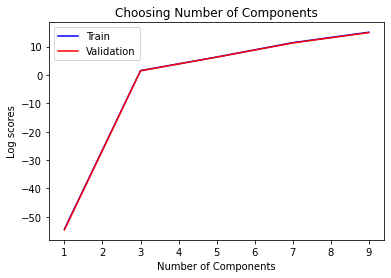

In [115]:
plt.plot(np.arange(1,10,2), log_scores_train_M8, color = 'blue', label = 'Train')
plt.plot(np.arange(1,10,2), log_scores_val_M8, color = 'red', label = 'Validation')
plt.title('Choosing Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Log scores')
plt.legend()

In [116]:
List_1G.append(['Five Features, One Gaussian, 1 components', col_names_M8, model_8_df.loc[0, 'AUC Train'], model_8_df.loc[0, 'AUC Val'], model_8_df.loc[0, 'F1 Score (Train)'], model_8_df.loc[0, 'F1 Score (Val)'], model_8_df.loc[0, 'F1 Threshold (Val)'], 'N/A'])

In [117]:
#MODEL 9
#all features, Two Gaussian, 1 for valid, finding the best component for invalid  through F1 scores on validation set
model_9_df = pd.DataFrame()
col_names_M9 = X.columns
for i in (range(1, 10, 2)):
  G1_M9 = fit_model(X_train.loc[df['Class'] == 0, col_names_M9], no_components = 1)
  G2_M9 = fit_model(X_train.loc[df['Class'] == 1, col_names_M9], no_components = i)
  S1_M9 = G1_M9.score_samples(np.array([X_val[col_names_M9]]).reshape(-1, 30))
  S2_M9 = G2_M9.score_samples(np.array([X_val[col_names_M9]]).reshape(-1, 30))
  S1_train_M9 = G1_M9.score_samples(np.array([X_train[col_names_M9]]).reshape(-1, 30))
  S2_train_M9 = G2_M9.score_samples(np.array([X_train[col_names_M9]]).reshape(-1, 30))
  F1_scores_M9 = []
  max_F1_Val_M9 = 0
  best_threshold_M9 = 0
  count = 0
  for j in np.arange(0,10,0.05):
    F1_scores_M9.append(f1_score(y_val.values, S1_M9 < j*S2_M9))
    if count == 0 or max_F1_Val_M9 < F1_scores_M9[count]:
      max_F1_Val_M9 = F1_scores_M9[count]
      best_threshold_M9 = j
    count = count + 1
  max_F1_Train_M9 = f1_score(y_train.values, S1_train_M9 < best_threshold_M9*S2_train_M9)      
  model_9_df = model_9_df.append({
      'F1 Score (Train)': max_F1_Train_M9,
      'F1 Score (Val)': max_F1_Val_M9,
      'C value (Val)': best_threshold_M9,
      'Number of Components': i
  }, ignore_index=True)

In [119]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features", col_names_M7, 'are shown you')
model_9_df = model_9_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_9_df

The F1 scores of the validation set based on different thresholds for a model fit on the features ['V14', 'V11', 'V10', 'V16', 'V12', 'V17', 'V3', 'V4', 'V27', 'V7'] are shown you


,C value (Val),F1 Score (Train),F1 Score (Val),Number of Components
0,5.30,0.797619,0.851613,3.0
1,5.45,0.818731,0.836601,5.0
2,5.25,0.720000,0.809816,1.0
3,3.95,0.827089,0.807947,7.0
4,4.15,0.868035,0.797297,9.0


In [163]:
List_2G.append(['2 Gaussian, 6 features, v - 1 comp., F - 3 comp.', list(col_names_M9), 'N/A', 'N/A', model_9_df.loc[0,'F1 Score (Train)'], model_9_df.loc[0,'F1 Score (Val)'],'N/A', model_9_df.loc[0,'C value (Val)']])

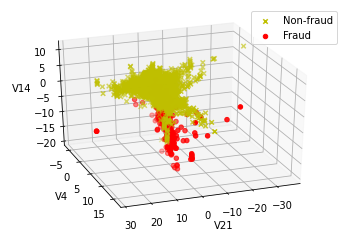

In [121]:
#MODEL 10
#Three features, Single Gaussian only on Fraudulent Transactions, 1 Component
plot_3d(X_train, y_train, f1="V21", f2="V4", f3="V14", angle=70 )

In [122]:
#Finding the component for best validation log likelihood scores, and then finding the optimum F1 score and threshold values
log_scores_val_M10 = []
log_scores_train_M10 = []
model_10_df = pd.DataFrame()
col_names_M10 = ['V21', 'V4', 'V14']
for i in (range(1,5)):
  
  gm_M10 = fit_model(X_train.loc[df['Class']==1, col_names_M10], no_components = i)
  pgm_M10_tr, AUC_M10_tr, log_sc_tr= AUC_Score_SG(gm_M10, X_train.loc[:, col_names_M10], y_train, log_gmm_score = 'YES')
  pgm_M10_va, AUC_M10_va, log_sc_v= AUC_Score_SG(gm_M10, X_val.loc[:, col_names_M10], y_val, log_gmm_score = 'YES')

  val_F1, val_threshold_F1= Best_F1_score(pgm_M10_va, y_val) 
  train_F1= f1_score(y_train, pgm_M10_tr < val_threshold_F1)
  log_scores_train_M10.append(log_sc_tr)
  log_scores_val_M10.append(log_sc_v)

  model_10_df = model_10_df.append({
      'AUC Train': AUC_M10_tr,
      'AUC Val': AUC_M10_va,
      'F1 Score (Train)': train_F1,
      'F1 Score (Val)': val_F1,
      'F1 Threshold (Val)': val_threshold_F1,
      'Log Scores (Train)': 1-log_sc_tr,
      'Log Scores (Val)': 1-log_sc_v,
      'Number of Components': i
  }, ignore_index=True)


In [124]:
print("The F1 scores of the validation set based on different thresholds for a model fit on the features",col_names_M8,"are shown here" )
model_10_df = model_10_df.sort_values(by = 'F1 Score (Val)', ascending = False).reset_index(drop=True)
model_10_df

The F1 scores of the validation set based on different thresholds for a model fit on the features Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object') are shown here


,AUC Train,AUC Val,F1 Score (Train),F1 Score (Val),F1 Threshold (Val),Log Scores (Train),Log Scores (Val),Number of Components
0,0.200132,0.214658,0.024648,0.061069,-12.944166,9.162299,9.157538,1.0
1,0.361827,0.386258,0.000000,0.000000,-78.679929,7.726184,7.721286,2.0
2,0.346017,0.357747,0.000000,0.000000,-144.670316,7.727941,7.722744,3.0
3,0.348156,0.363191,0.000000,0.000000,-197.862571,7.729106,7.724717,4.0


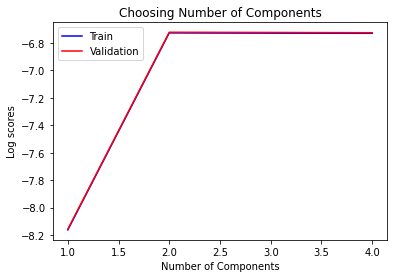

In [125]:
plt.plot(np.arange(1,5), log_scores_train_M10, color = 'blue', label = 'Train')
plt.plot(np.arange(1,5), log_scores_val_M10, color = 'red', label = 'Validation')
plt.title('Choosing Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Log scores')
plt.legend()

In [126]:
List_1G.append(['Five Features, One Gaussian, 1 components', col_names_M8, model_8_df.loc[0, 'AUC Train'], model_8_df.loc[0, 'AUC Val'], model_8_df.loc[0, 'F1 Score (Train)'], model_8_df.loc[0, 'F1 Score (Val)'], model_8_df.loc[0, 'F1 Threshold (Val)'], 'N/A'])

In [128]:
print("The final best 4 Single Gaussian Models are shown below")
OneG_Final_df = pd.DataFrame( List_1G, columns = ['Model Type', 'Features', 'AUC_Train', 'AUC_Val', 'Max_F1_Train', 'Max_F1_Val', 'Best_threshold', 'Best c Value'])
OneG_Final_df

The final best 4 Single Gaussian Models are shown below


,Model Type,Features,AUC_Train,AUC_Val,Max_F1_Train,Max_F1_Val,Best_threshold,Best c Value
0,"Five Features, One Gaussian, 20 components","[V14, V11, V10, V16, V12]",0.962593,0.966839,0.423490,0.462633,-15.450587,N/A
1,"Thirteen Features, One Gaussian, 1 component","[V10, V16, V12, V17, V3, V4, V27, V7, V2, V18,...",0.950183,0.957847,0.287926,0.351145,-279.753146,N/A
2,"Five Features, One Gaussian, 1 components","Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', '...",0.950984,0.957271,0.268174,0.290076,-651.543261,N/A
3,"Five Features, One Gaussian, 1 components","Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', '...",0.950984,0.957271,0.268174,0.290076,-651.543261,N/A


In [164]:
print("The final best 6 Two Gaussian Models are shown below")
TwoG_Final_df = pd.DataFrame(List_2G, columns = ['Model Type','Features', 'AUC_Train', 'AUC_Val', 'Max_F1_Train', 'Max_F1_Val','Best_threshold', 'Best c Value'])
TwoG_Final_df= TwoG_Final_df.sort_values(by = 'Max_F1_Val', ascending = False).reset_index(drop=True)
TwoG_Final_df

The final best 6 Two Gaussian Models are shown below


,Model Type,Features,AUC_Train,AUC_Val,Max_F1_Train,Max_F1_Val,Best_threshold,Best c Value
0,"2 Gaussian, 6 feat., v- 1 comp., F - 10 comp.","[V14, V11, V10, V16, V12, V17]",N/A,N/A,0.819423,0.886076,N/A,6.55
1,"2 Gaussian, 6 feat., v - 1 comp., F - 3 comp.","[V14, V11, V10, V16, V12, V17, V3, V4, V27, V7]",N/A,N/A,0.809741,0.878981,N/A,6.65
2,"2 Gaussian, 6 features, v - 1 comp., F - 3 comp.","[Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10...",N/A,N/A,0.797619,0.851613,N/A,5.30
3,"Three Features, 2 Gaussians, 1 component","[V10, V16, V11]",N/A,N/A,0.662069,0.757143,N/A,3.90
4,"Two Features, 2 Gaussians, 1 component","[V17, V11]",N/A,N/A,0.666667,0.737589,N/A,5.85
5,"Two Features, 2 Gaussians, 1 component","[V17, V14]",N/A,N/A,0.472590,0.508475,N/A,5.25


## **Evaluating performance on test set:**


In [170]:
#from TwoG_Final_df and OneG_Final_df it is clear that 2 Gaussian Model with 6 features and 10 components works best


G1_M6 = fit_model(X_train.loc[df['Class'] == 0, col_names_M6], no_components=1)
G2_M6 = fit_model(X_train.loc[df['Class'] == 1, col_names_M6], no_components=i)
S1_M6_test = G1_M6.score_samples(np.array([X_test[col_names_M6]]).reshape(-1, 6))
S2_M6_test = G2_M6.score_samples(np.array([X_test[col_names_M6]]).reshape(-1, 6))


max_F1_Test = f1_score(y_test.values, S1_M6_test < TwoG_Final_df.loc[0,'Best c Value']*S2_M6_test)  #threshold taken from model 6 which had the highest value 


In [171]:
print("The maximum F1 score on test set for the best model is",max_F1_Test)

The maximum F1 score on test set for the best model is 0.7575757575757576


In [172]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(y_test, S1_M6_test < TwoG_Final_df.loc[0,'Best c Value']*S2_M6_test) 
recall = recall_score(y_test, S1_M6_test < TwoG_Final_df.loc[0,'Best c Value']*S2_M6_test) 

In [173]:
print("The recall on test set for the best model is",recall)

The recall on test set for the best model is 0.7246376811594203


In [174]:
print("The precision on test set for the best model is",precision)

The precision on test set for the best model is 0.7936507936507936
